In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
import traceback
from astropy.constants import G
import astropy.units as u
import symlib
import colossus.cosmology as cosmology

sim_colors = {
    'SymphonyLMC': sns.color_palette("colorblind")[4],
    'SymphonyMilkyWay': sns.color_palette("colorblind")[0],
    'SymphonyGroup': sns.color_palette("colorblind")[2],
    'SymphonyLCluster': sns.color_palette("colorblind")[1],
    'SymphonyCluster': sns.color_palette("colorblind")[3]
}

In [26]:
def plot_combined_ppsd_and_slopes(base_dir, suite_names):
    from matplotlib import gridspec

    fig_ppsd = plt.figure(figsize=(14, 12), dpi=500)
    gs_ppsd = gridspec.GridSpec(3, 2, height_ratios=[3, 3, 1])
    ax_ppsd = [fig_ppsd.add_subplot(gs_ppsd[0, 0]),
               fig_ppsd.add_subplot(gs_ppsd[0, 1]),
               fig_ppsd.add_subplot(gs_ppsd[1, 0]),
               fig_ppsd.add_subplot(gs_ppsd[1, 1])]
    ax_resid = [fig_ppsd.add_subplot(gs_ppsd[2, 0]),
                fig_ppsd.add_subplot(gs_ppsd[2, 1])]

    fig_slope, axes_slope = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    ax_slope = axes_slope.flatten()

    interp_m = np.logspace(-4, 0, 200)

    def load_ppsd_profiles(suite):
        dir_path = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(dir_path) if f.endswith(".csv")])
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []
        for f in files:
            df = pd.read_csv(os.path.join(dir_path, f))
            r_list.append(df["r_scaled"].values)
            m_list.append(df["m_scaled"].values)
            Qr_list.append(df["Q_r"].values)
            Qtot_list.append(df["Q_tot"].values)
        return r_list, m_list, Qr_list, Qtot_list

    def load_slope_profiles(suite):
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        dir_m = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        files_r = sorted([f for f in os.listdir(dir_r) if f.endswith(".csv")])
        files_m = sorted([f for f in os.listdir(dir_m) if f.endswith(".csv")])
        r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot = [], [], [], [], [], []
        for fr, fm in zip(files_r, files_m):
            dfr = pd.read_csv(os.path.join(dir_r, fr))
            dfm = pd.read_csv(os.path.join(dir_m, fm))
            r_list.append(dfr["r_scaled"].values)
            m_list.append(dfm["m_scaled"].values)
            slope_r_Qr.append(dfr["slope_Q_r"].values)
            slope_r_Qtot.append(dfr["slope_Q_tot"].values)
            slope_m_Qr.append(dfm["slope_Q_r"].values)
            slope_m_Qtot.append(dfm["slope_Q_tot"].values)
        return r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot

    def interpolate_curves(x_target, x_list, y_list):
        return np.array([
            np.interp(x_target, x, y, left=np.nan, right=np.nan)
            for x, y in zip(x_list, y_list)
            if np.all(np.isfinite(x)) and np.all(np.isfinite(y))
        ])

    Qr_all_r, Qtot_all_r, r_all = [], [], []

    for suite in suite_names:
        color = sim_colors.get(suite, "gray")
        r_list, m_list, Qr_list, Qtot_list = load_ppsd_profiles(suite)

        # Use radius directly without interpolation
        Qr_all_r.extend(Qr_list)
        Qtot_all_r.extend(Qtot_list)
        r_all = r_list[0]  # Assuming aligned

        Qr_arr = np.array(Qr_list)
        Qtot_arr = np.array(Qtot_list)

        for ax, data in zip(ax_ppsd[:2], [Qr_arr, Qtot_arr]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(r_list[0], mean, color=color, label=suite)
            ax.fill_between(r_list[0], mean - std, mean + std, color=color, alpha=0.3)

        Qr_interp_m = interpolate_curves(interp_m, m_list, Qr_list)
        Qtot_interp_m = interpolate_curves(interp_m, m_list, Qtot_list)

        for ax, data in zip(ax_ppsd[2:], [Qr_interp_m, Qtot_interp_m]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(interp_m, mean, color=color, label=suite)
            ax.fill_between(interp_m, mean - std, mean + std, color=color, alpha=0.3)

        r_slope, m_slope, sr_Qr, sr_Qtot, sm_Qr, sm_Qtot = load_slope_profiles(suite)

        slope_interp_m_Qr = interpolate_curves(interp_m, m_slope, sm_Qr)
        slope_interp_m_Qtot = interpolate_curves(interp_m, m_slope, sm_Qtot)

        for i, (interp, x_vals) in enumerate(zip(
            [sr_Qr, sr_Qtot, slope_interp_m_Qr, slope_interp_m_Qtot],
            [r_list[0], r_list[0], interp_m, interp_m])):
            data = np.array(interp)
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax_slope[i].plot(x_vals, mean, color=color, label=suite)
            ax_slope[i].fill_between(x_vals, mean - std, mean + std, color=color, alpha=0.3)

        mean_Qr = np.nanmean(Qr_arr, axis=0)
        mean_Qtot = np.nanmean(Qtot_arr, axis=0)
        A_r = np.exp(np.nanmean(np.log(mean_Qr) + 1.875 * np.log(r_list[0])))
        A_tot = np.exp(np.nanmean(np.log(mean_Qtot) + 1.875 * np.log(r_list[0])))
        ref_Qr = A_r * r_list[0]**(-1.875)
        ref_Qtot = A_tot * r_list[0]**(-1.875)

        resid_Qr = np.log10(Qr_arr / ref_Qr)
        resid_Qtot = np.log10(Qtot_arr / ref_Qtot)

        ax_resid[0].plot(r_list[0], np.nanmean(resid_Qr, axis=0), color=color, label=suite)
        ax_resid[1].plot(r_list[0], np.nanmean(resid_Qtot, axis=0), color=color, label=suite)
        
    labels = ["$Q_r$ vs $r$", "$Q_{tot}$ vs $r$", "$Q_r$ vs $M$", "$Q_{tot}$ vs $M$"]
    for i, ax in enumerate(ax_ppsd):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Q")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    for ax in ax_resid:
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$")
        ax.set_ylabel("log$_{10}$(residual)")
        ax.grid(True, which="both", linestyle=":")


    for i, ax in enumerate(ax_slope):
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Slope")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.axhline(-1.875, color="black", lw=0.9, ls="--")
        ax.legend()

    fig_ppsd.suptitle("PPSD Profiles with Residuals: Mean ± 1σ across Suites", fontsize=16)
    fig_slope.suptitle("PPSD Slope Profiles: Mean ± 1σ across Suites", fontsize=16)

    out_dir = os.path.join(base_dir, "output", "Combined")
    os.makedirs(out_dir, exist_ok=True)
    fig_ppsd.tight_layout(rect=[0, 0, 1, 0.96])
    fig_slope.tight_layout(rect=[0, 0, 1, 0.96])
    fig_ppsd.savefig(os.path.join(out_dir, "ppsd_profiles_comparison_with_residuals.png"))
    fig_slope.savefig(os.path.join(out_dir, "ppsd_slope_profiles_comparison.png"))
    plt.show()

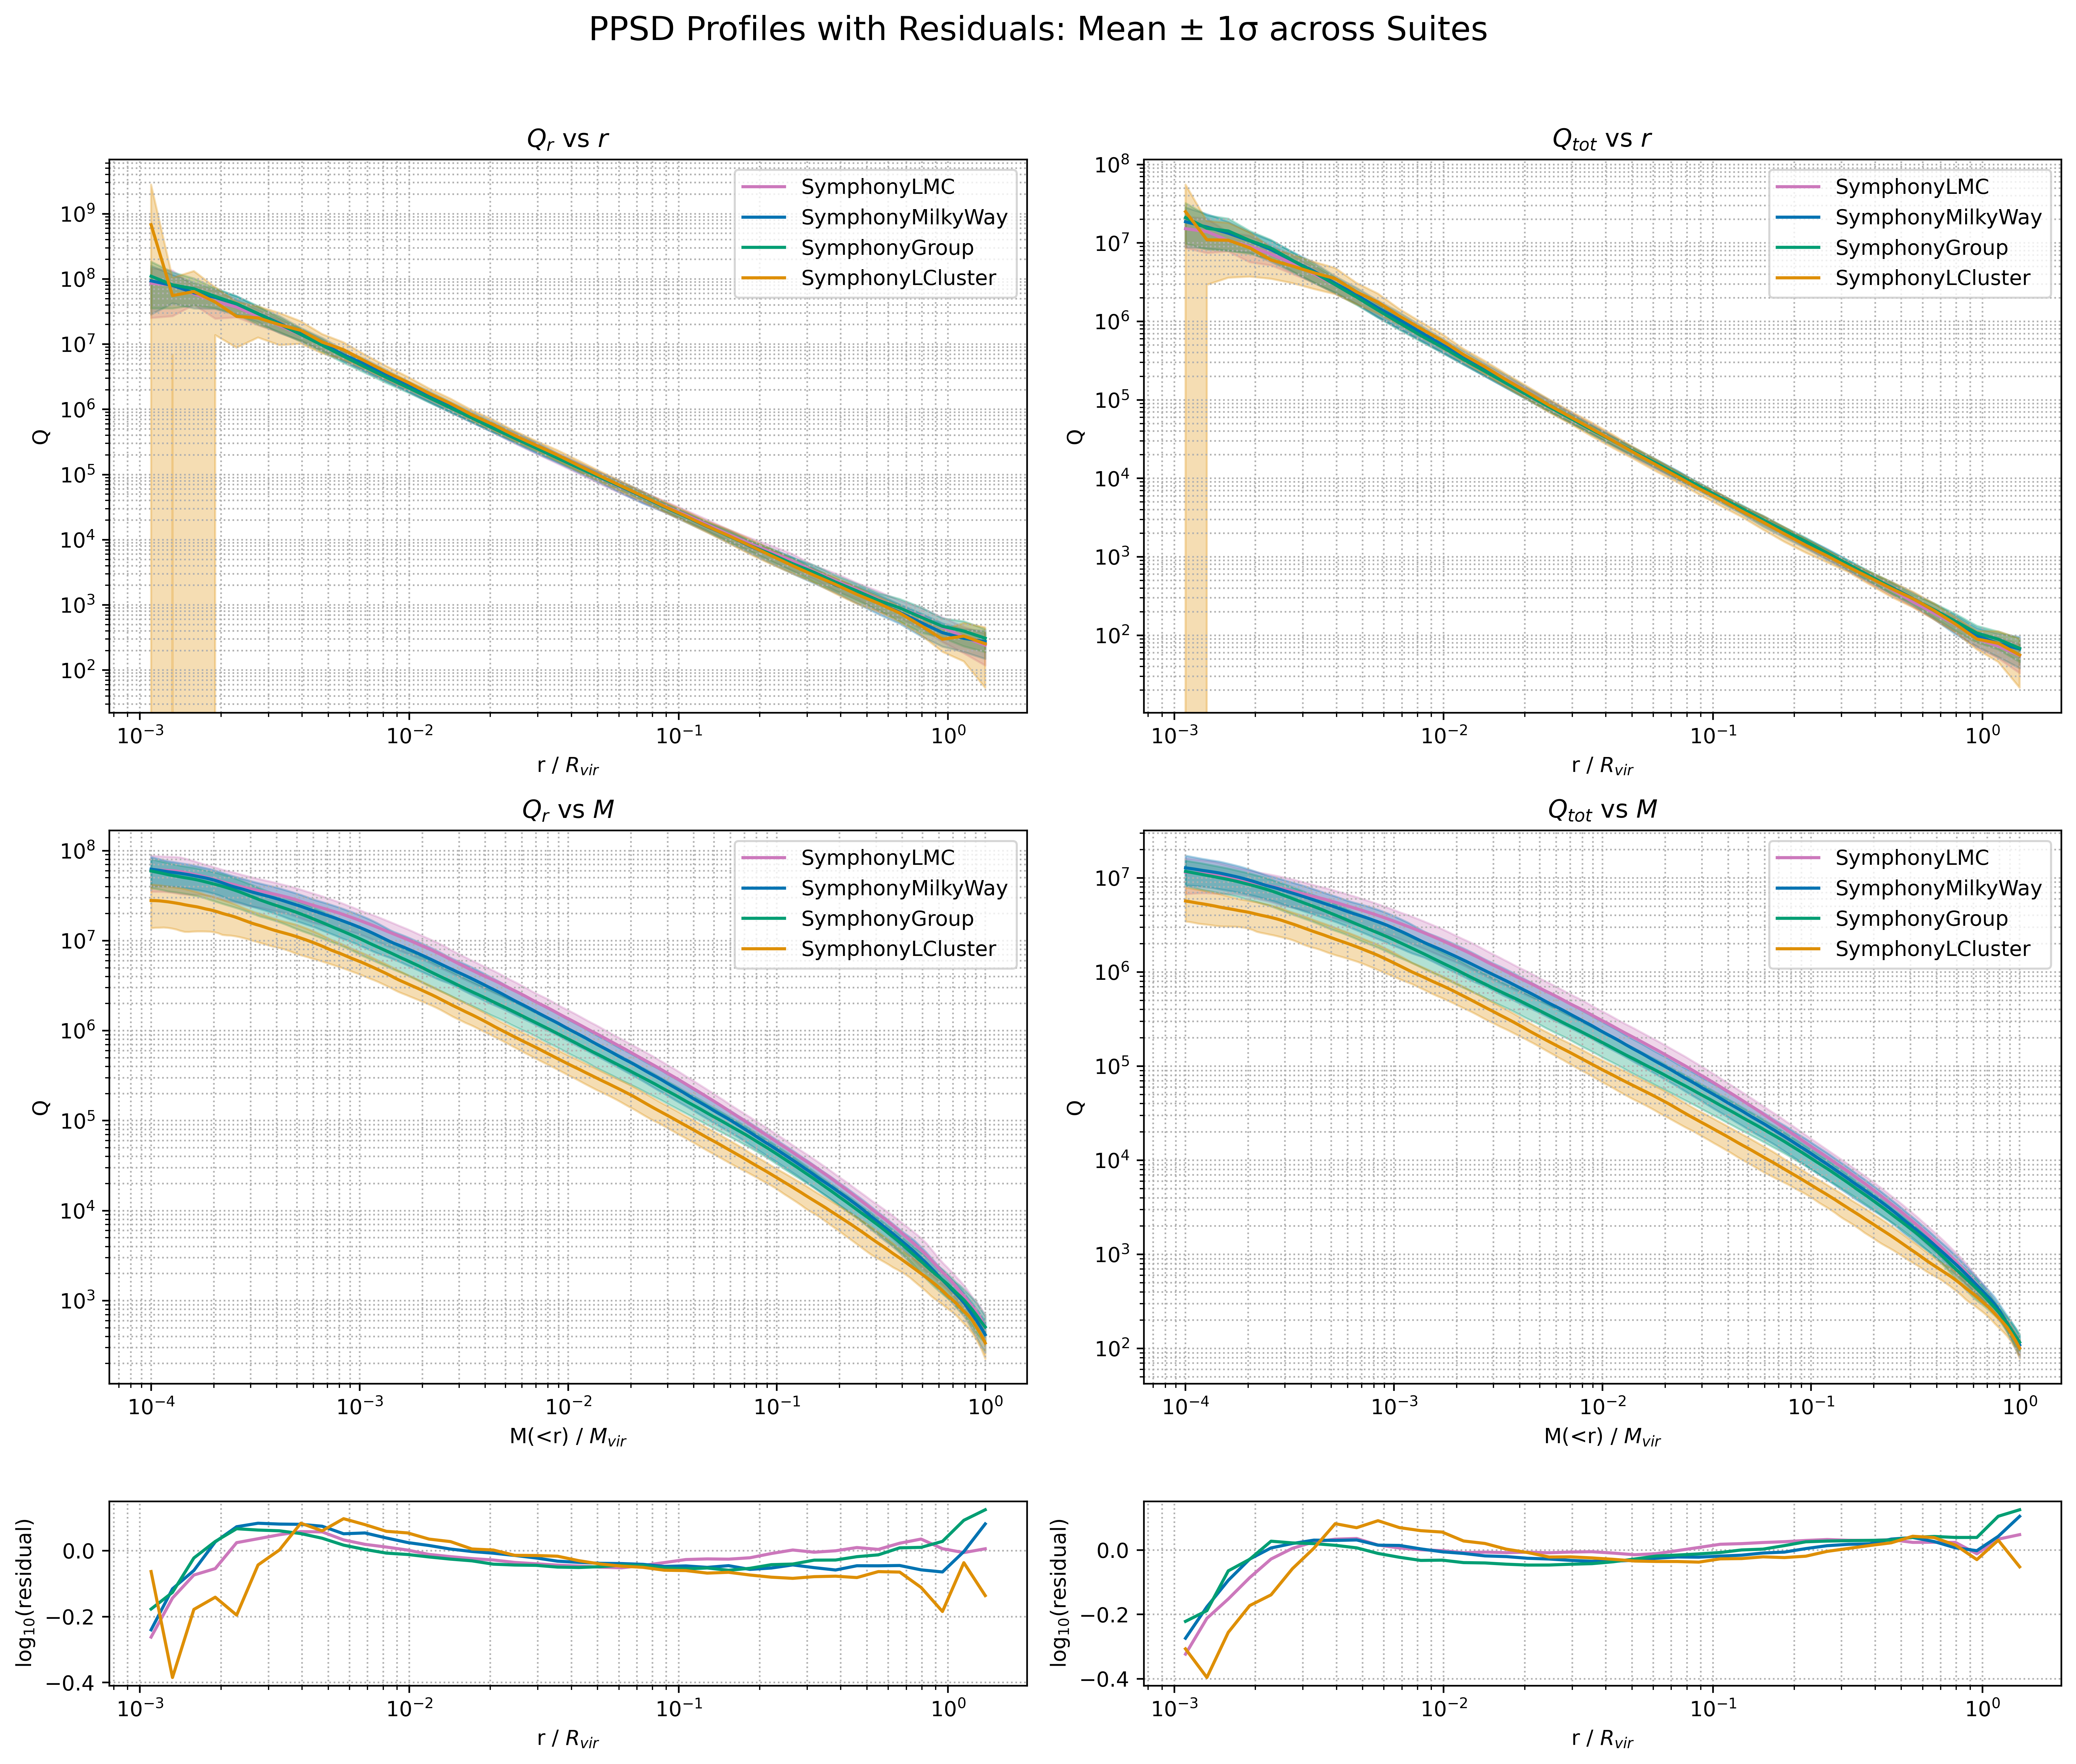

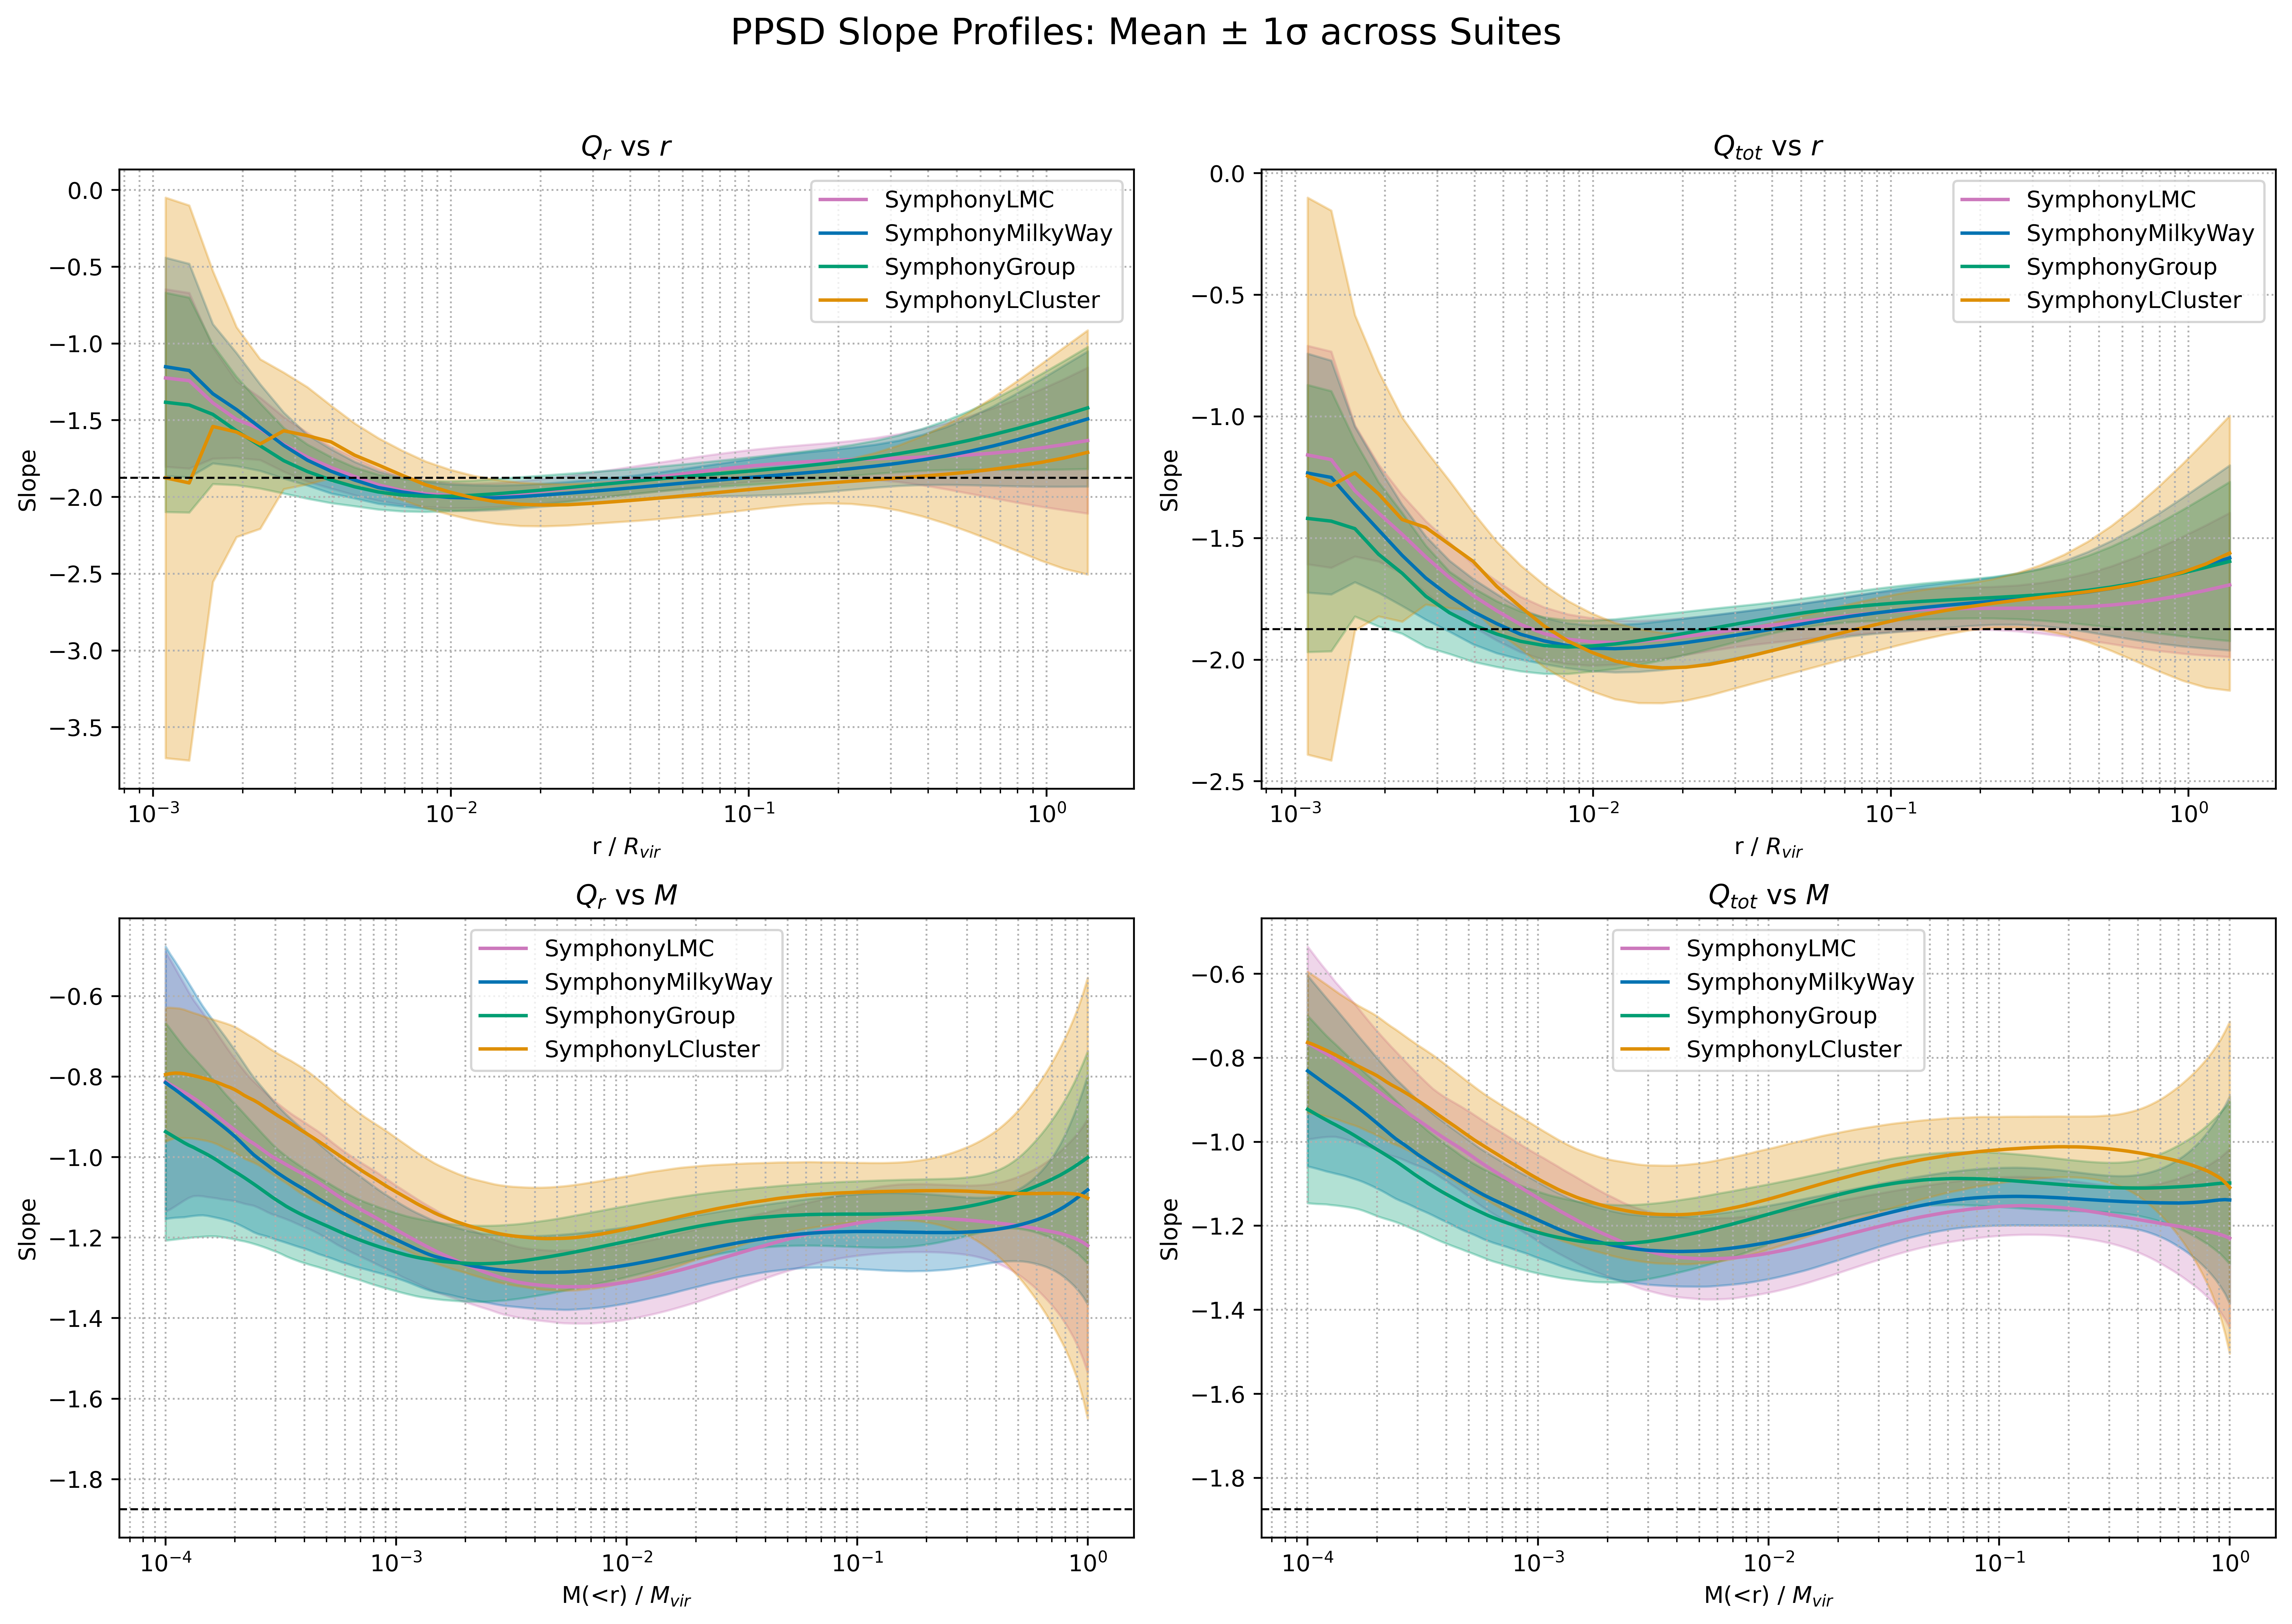

In [27]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster"
]

plot_combined_ppsd_and_slopes(base_dir, suite_names)

In [34]:
def plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names):
    def mean_std_plot(ax, x_list, y_list, mean_param, label_prefix, color, sci=False):
        if len(x_list) == 0 or len(y_list) == 0:
            return
        x_ref = x_list[0]
        y_stack = np.stack(y_list)
        y_mean = np.nanmean(y_stack, axis=0)
        y_std = np.nanstd(y_stack, axis=0)
        param_fmt = f"{mean_param:.2e}" if sci else f"{mean_param:.2f}"
        label = f"{label_prefix} (⟨⟩={param_fmt}, N={len(y_list)})"
        ax.plot(x_ref, y_mean, color=color, lw=0.9, label=label)
        ax.fill_between(x_ref, y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)

    r_low, r_high, m_low, m_high = [], [], [], []
    Qr_low_c, Qr_high_c, Qtot_low_c, Qtot_high_c = [], [], [], []
    Qr_low_g, Qr_high_g, Qtot_low_g, Qtot_high_g = [], [], [], []
    cvir_low, cvir_high, gamma_low, gamma_high = [], [], [], []
    cvir_medians, gamma_medians = [], []

    for suite in suite_names:
        ppsd_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(ppsd_dir) if f.endswith(".csv")])

        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        acc_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        cvir_df = pd.read_csv(cvir_path)
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        df_gamma = pd.read_csv(acc_path)
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))

        cvir_list, gamma_list = [], []
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []

        for i, f in enumerate(files):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(ppsd_dir, f))
                r = df["r_scaled"].values
                m = df["m_scaled"].values
                Qr = df["Q_r"].values
                Qtot = df["Q_tot"].values

                cvir = cvir_dict.get(halo_id, np.nan)
                gamma = gamma_dict.get(halo_id, np.nan)
            except:
                continue

            r_list.append(r)
            m_list.append(m)
            Qr_list.append(Qr)
            Qtot_list.append(Qtot)
            cvir_list.append(cvir)
            gamma_list.append(gamma)

        cvir_median = np.nanmedian(cvir_list)
        gamma_median = np.nanmedian(gamma_list)
        cvir_medians.append(cvir_median)
        gamma_medians.append(gamma_median)

        for r, m, Qr, Qtot, c, g in zip(r_list, m_list, Qr_list, Qtot_list, cvir_list, gamma_list):
            if not np.all(np.isfinite(Qr)) or not np.all(np.isfinite(Qtot)):
                continue
            if c <= cvir_median:
                r_low.append(r)
                m_low.append(m)
                Qr_low_c.append(Qr)
                Qtot_low_c.append(Qtot)
                cvir_low.append(c)
            else:
                r_high.append(r)
                m_high.append(m)
                Qr_high_c.append(Qr)
                Qtot_high_c.append(Qtot)
                cvir_high.append(c)

            if g <= gamma_median:
                Qr_low_g.append(Qr)
                Qtot_low_g.append(Qtot)
                gamma_low.append(g)
            else:
                Qr_high_g.append(Qr)
                Qtot_high_g.append(Qtot)
                gamma_high.append(g)

    def finalize(axs, r_Qr, r_Qtot, m_Qr, m_Qtot,
                 low_label, high_label, colors,
                 low_param, high_param, sci=False):
        mean_std_plot(axs[0], r_low, r_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[0], r_high, r_Qr[1], high_param, high_label, colors[1], sci)
        axs[0].set_title(r"$Q_r$ vs $r$")

        mean_std_plot(axs[1], r_low, r_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[1], r_high, r_Qtot[1], high_param, high_label, colors[1], sci)
        axs[1].set_title(r"$Q_{\rm tot}$ vs $r$")

        mean_std_plot(axs[2], m_low, m_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[2], m_high, m_Qr[1], high_param, high_label, colors[1], sci)
        axs[2].set_title(r"$Q_r$ vs $M$")

        mean_std_plot(axs[3], m_low, m_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[3], m_high, m_Qtot[1], high_param, high_label, colors[1], sci)
        axs[3].set_title(r"$Q_{\rm tot}$ vs $M$")

        for ax in axs:
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel("r / Rvir" if "r" in ax.get_title() else "M / Mvir")
            ax.set_ylabel("PPSD")
            ax.grid(True, which="both", linestyle=":")
            ax.legend()

    os.makedirs(os.path.join(base_dir, "output", "combined", "figures"), exist_ok=True)

    fig_c, axes_c = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_c.flatten(),
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             "Low c", "High c", ["steelblue", "firebrick"],
             np.mean(cvir_low), np.mean(cvir_high), sci=False)
    fig_c.suptitle("PPSD by Concentration (Per-suite split)", fontsize=16)
    fig_c.tight_layout(rect=[0, 0, 1, 0.96])
    fig_c.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_concentration.png"))

    fig_a, axes_a = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_a.flatten(),
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             "Low Accretion", "High Accretion", ["seagreen", "orange"],
             np.mean(gamma_low), np.mean(gamma_high), sci=True)
    fig_a.suptitle("PPSD by Accretion Rate (Per-suite split)", fontsize=16)
    fig_a.tight_layout(rect=[0, 0, 1, 0.96])
    fig_a.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_accretion.png"))

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup"
]

plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names)

In [ ]:
def plot_ppsd_slope_split_by_concentration_and_accretion(base_dir, suite_names):
    def load_slopes(suite):
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        slope_m_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        acc_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")

        cvir_df = pd.read_csv(cvir_path)
        gamma_df = pd.read_csv(acc_path) 
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        gamma_dict = dict(zip(gamma_df["halo_index"], gamma_df["gamma"]))

        slopes = {"r_Qtot": [], "r_Qr": [], "m_Qtot": [], "m_Qr": [],
                "r": None, "M_common": np.logspace(-5, 0, 200),
                "cvir": [], "gamma": []}

        files = sorted([f for f in os.listdir(slope_r_dir) if f.startswith("halo_") and f.endswith(".csv")])
        for f in files:
            try:
                halo_id = int(f.split("_")[1])  
                r_file = os.path.join(slope_r_dir, f)
                m_file = os.path.join(slope_m_dir, f)

                dfr = pd.read_csv(r_file)
                dfm = pd.read_csv(m_file)

                r = dfr["r_scaled"].values
                m = dfm["m_scaled"].values
                sr_Qtot = dfr["slope_Q_tot"].values
                sr_Qr = dfr["slope_Q_r"].values
                sm_Qtot = dfm["slope_Q_tot"].values
                sm_Qr = dfm["slope_Q_r"].values

                if slopes["r"] is None:
                    slopes["r"] = r

                M_common = slopes["M_common"]
                interp_Qtot = np.interp(M_common, m, sm_Qtot, left=np.nan, right=np.nan)
                interp_Qr = np.interp(M_common, m, sm_Qr, left=np.nan, right=np.nan)

                slopes["r_Qtot"].append(sr_Qtot)
                slopes["r_Qr"].append(sr_Qr)
                slopes["m_Qtot"].append(interp_Qtot)
                slopes["m_Qr"].append(interp_Qr)

                slopes["cvir"].append(cvir_dict.get(halo_id, np.nan))
                slopes["gamma"].append(gamma_dict.get(halo_id, np.nan))
            except Exception as e:
                print(f"[Warning] Halo {f} in {suite} failed: {e}")
                continue

        return slopes
    def stack_by_split(slopes, key, by="cvir"):
        x = slopes["r"] if "r_" in key else slopes["M_common"]
        y_data = slopes[key]
        group = np.array(slopes[by])
        y_data = np.array(y_data)

        median_val = np.nanmedian(group)
        high = y_data[group > median_val]
        low = y_data[group <= median_val]

        def mean_std(yset):
            y_stack = np.stack([y for y in yset if np.all(np.isfinite(y))])
            y_mean = np.nanmean(y_stack, axis=0)
            y_std = np.nanstd(y_stack, axis=0)
            return y_mean, y_std

        return x, *mean_std(low), *mean_std(high), median_val

    def plot_split_figure(all_slopes, split_by, save_name, title_label):
        fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=500, constrained_layout=True)
        labels = [r"$\mathrm{d}\log Q / \mathrm{d}\log r$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log r$",
                  r"$\mathrm{d}\log Q / \mathrm{d}\log M$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log M$"]
        keys = ["r_Qtot", "r_Qr", "m_Qtot", "m_Qr"]
        xlabels = [r"$r / R_{\mathrm{vir}}$", r"$r / R_{\mathrm{vir}}$",
                   r"$M(<r) / M_{\mathrm{vir}}$", r"$M(<r) / M_{\mathrm{vir}}$"]

        for i, ax in enumerate(axs.flat):
            all_x = []
            all_low_mean, all_low_std = [], []
            all_high_mean, all_high_std = [], []
            for slopes in all_slopes:
                x, low_mean, low_std, high_mean, high_std, med = stack_by_split(slopes, keys[i], by=split_by)
                all_x = x
                all_low_mean.append(low_mean)
                all_low_std.append(low_std)
                all_high_mean.append(high_mean)
                all_high_std.append(high_std)

            mean_low = np.nanmean(np.stack(all_low_mean), axis=0)
            std_low = np.nanstd(np.stack(all_low_mean), axis=0)
            mean_high = np.nanmean(np.stack(all_high_mean), axis=0)
            std_high = np.nanstd(np.stack(all_high_mean), axis=0)

            ax.plot(all_x, mean_low, color="blue", label=f"Low {title_label}", lw=1)
            ax.fill_between(all_x, mean_low - std_low, mean_low + std_low, color="blue", alpha=0.3)

            ax.plot(all_x, mean_high, color="red", label=f"High {title_label}", lw=1)
            ax.fill_between(all_x, mean_high - std_high, mean_high + std_high, color="red", alpha=0.3)

            ax.set_xlabel(xlabels[i])
            ax.set_ylabel(labels[i])
            ax.set_xscale("log")
            ax.set_ylim(-3, 0)
            ax.grid(True, which="both", linestyle=":")
            ax.legend()

        fig.suptitle(f"PPSD Slopes Split by {title_label}", fontsize=16)
        fig.savefig(os.path.join(base_dir, "output", "Combined", f"{save_name}.png"))
        plt.close(fig)

    # --- Load and plot ---
    all_suite_slopes = []
    for suite in suite_names:
        slopes = load_slopes(suite)
        all_suite_slopes.append(slopes)

    plot_split_figure(all_suite_slopes, "cvir", "ppsd_slopes_split_by_concentration", "Concentration")
    plot_split_figure(all_suite_slopes, "gamma", "ppsd_slopes_split_by_accretion", "Accretion Rate")

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup"
]

plot_ppsd_slope_split_by_concentration_and_accretion(base_dir, suite_names)